In [ ]:
!pip install pandas numpy yfinance statsmodels scikit-learn keras matplotlib alpha-vantage vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.0 MB/s eta 0:00:00


In [ ]:
# **************** IMPORT PACKAGES ********************
import yfinance as yf
import requests
import csv
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import os
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from alpha_vantage.timeseries import TimeSeries
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# **************** FUNCTIONS TO FETCH DATA ***************************

def get_historical(quote):
    end = datetime.now()
    start = datetime(end.year - 2, end.month, end.day)
    data = yf.download(quote, start=start, end=end)
    df = pd.DataFrame(data=data)
    df.to_csv(f'{quote}.csv')

    if df.empty:
        ts = TimeSeries(key='N6A6QT6IBFJOPJ70', output_format='pandas')
        data, meta_data = ts.get_daily_adjusted(symbol='NSE:' + quote, outputsize='full')
        data = data.head(503).iloc[::-1].reset_index()

        df = pd.DataFrame({
            'Date': data['date'],
            'Open': data['1. open'],
            'High': data['2. high'],
            'Low': data['3. low'],
            'Close': data['4. close'],
            'Adj Close': data['5. adjusted close'],
            'Volume': data['6. volume']
        })
        df.to_csv(f'{quote}.csv', index=False)
    return df

In [ ]:
# ******************** ARIMA SECTION ********************
def ARIMA_ALGO(df, quote=None):
    """
    Perform ARIMA-based stock price prediction on a given DataFrame.
    If a specific company (quote) is provided, the prediction will focus on it.
    """

    # Helper function to parse dates
    def parser(x):
        return datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S%z')

    # ARIMA model implementation
    def arima_model(train, test):
        history = [x for x in train]  # Initialize with training data
        predictions = []

        for t in range(len(test)):
            model = ARIMA(history, order=(6, 1, 0))  # ARIMA(6,1,0)
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]  # Get one-step forecast
            predictions.append(yhat)
            history.append(test[t])  # Update history with observed value

        return predictions

    # Filter DataFrame if specific quote is provided
    if quote:
        df = df[df['Code'] == quote]

    unique_companies = df["Code"].unique()  # Get unique company codes

    # Iterate over companies (or just one if quote provided)
    for company in unique_companies[:10]:
        data = df[df['Code'] == company].reset_index()
        data['Price'] = data['Close']  # Use 'Close' column for prediction
        data.index = data['Date'].map(parser)  # Parse dates for index

        # Prepare training and testing data
        price_values = np.nan_to_num(data['Price'].astype(float).values)  # Handle NaN values
        train_size = int(len(price_values) * 0.80)
        train, test = price_values[:train_size], price_values[train_size:]

        # Run the ARIMA model
        predictions = arima_model(train, test)

        # Plot actual vs predicted prices
        plt.figure(figsize=(10, 5))
        plt.plot(test, label='Actual Price')
        plt.plot(predictions, label='ARIMA Predictions', linestyle='--')
        plt.title(f'{company} - ARIMA Predictions vs Actual Prices')
        plt.legend()
        plt.show()

        # Calculate RMSE
        error_arima = math.sqrt(mean_squared_error(test, predictions))
        arima_pred = predictions[-1]  # Get the last prediction

        # Print results
        print(f"{company} - ARIMA RMSE: {error_arima}")
        print(f"Tomorrow's Predicted Closing Price by ARIMA: {arima_pred}")

In [ ]:
# **************** LINEAR REGRESSION SECTION ******************
def LINEAR_REGRESSION_ALGO(df, forecast_out=7):
    """
    Perform Linear Regression to predict stock prices n days into the future.
    Default forecast is 7 days ahead.
    """

    # Prepare the data
    df = df.reset_index()  # Reset index for clean DataFrame operations
    df['Day'] = (df['Date'] - df['Date'].min()).dt.days  # Compute days from the start
    df['Close after n days'] = df['Close'].shift(-forecast_out)  # Shift to forecast

    # Drop the last 'forecast_out' rows to avoid NaNs in target
    X = df[['Close']].values[:-forecast_out]
    y = df['Close after n days'].values[:-forecast_out].reshape(-1, 1)

    # Standardize the features
    sc = StandardScaler()
    X_train = sc.fit_transform(X[:int(0.8 * len(X))])  # First 80% for training
    X_test = sc.transform(X[int(0.8 * len(X)):])  # Last 20% for testing

    # Train the Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y[:int(0.8 * len(y))])

    # Predict stock prices and adjust the predictions
    y_pred = model.predict(X_test) * 1.04  # Adjust predictions slightly
    error_lr = math.sqrt(mean_squared_error(y[int(0.8 * len(y)):], y_pred))

    # Plot Actual vs Predicted prices
    plt.figure(figsize=(10, 5))
    plt.plot(y[int(0.8 * len(y)):], label='Actual Price', marker='o')
    plt.plot(y_pred, label='Linear Regression Predictions', linestyle='--')
    plt.title('Linear Regression: Actual vs Predicted Prices')
    plt.legend()
    plt.show()

    # Print RMSE for model evaluation
    print(f"Linear Regression RMSE: {error_lr}")

In [ ]:
# **************** LSTM SECTION **********************
def LSTM_ALGO(df):
    """
    Perform LSTM to predict stock prices based on historical data.
    """

    # Split the dataset into training and testing sets
    train_data = df.iloc[:int(0.8 * len(df)), 4:5].values  # Close prices for training
    test_data = df.iloc[int(0.8 * len(df)):, 4:5].values    # Close prices for testing

    # Scale the features
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)

    # Prepare training data
    X_train, y_train = [], []
    for i in range(7, len(train_scaled)):
        X_train.append(train_scaled[i - 7:i, 0])
        y_train.append(train_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # Reshape for LSTM input

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.1))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=50))
    model.add(Dropout(0.1))
    model.add(Dense(units=1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=25, batch_size=32)

    # Prepare testing data
    total_data = pd.concat((df['Close'][:int(0.8 * len(df))], df['Close'][int(0.8 * len(df)):]), axis=0)
    inputs = total_data[len(total_data) - len(test_data) - 7:].values.reshape(-1, 1)
    inputs = scaler.transform(inputs)

    X_test = []
    for i in range(7, len(inputs)):
        X_test.append(inputs[i - 7:i, 0])
    X_test = np.array(X_test).reshape(len(X_test), 7, 1)

    # Make predictions
    predicted_stock_price = model.predict(X_test)
    predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.plot(test_data, label='Actual Price', marker='o')
    plt.plot(predicted_stock_price, label='LSTM Predictions', linestyle='--')
    plt.title('LSTM: Actual vs Predicted Prices')
    plt.legend()
    plt.show()

    # Print RMSE
    error_lstm = math.sqrt(mean_squared_error(test_data, predicted_stock_price))
    print(f"LSTM RMSE: {error_lstm}")

In [ ]:
def fetch_tweets(query, cursor=None):
    url = "https://twitter-api45.p.rapidapi.com/search.php"
    headers = {
        "x-rapidapi-key": "4ec154cc17mshfb1a17a88a74772p159e36jsn6467a42c7d46",
        "x-rapidapi-host": "twitter-api45.p.rapidapi.com"
    }
    querystring = {"query": query, "search_type": "Latest"}
    if cursor:
        querystring["cursor"] = cursor

    response = requests.get(url, headers=headers, params=querystring)
    if response.status_code == 200:
        data = response.json()
        return data.get("timeline", []), data.get("next_cursor")
    else:
        print(f"Error: {response.status_code}")
        return [], None

def analyze_tweet_sentiment(tweets):
    analyzer = SentimentIntensityAnalyzer()
    global_polarity = 0
    positive_count = negative_count = 0

    for tweet in tweets:
        text = tweet.get("text", "")
        sentiment_score = analyzer.polarity_scores(text)
        global_polarity += sentiment_score["compound"]

        if sentiment_score["compound"] >= 0.05:
            positive_count += 1
        elif sentiment_score["compound"] <= -0.05:
            negative_count += 1

    return global_polarity, positive_count, negative_count

def retrieve_tweets_polarity(symbol):
    # Load stock ticker mapping
    stock_ticker_map = pd.read_csv('Yahoo-Finance-Ticker-Symbols.csv')
    symbol_name = stock_ticker_map[stock_ticker_map['Ticker'] == symbol]['Name'].values[0]

    print(f"Fetching tweets for {symbol_name}...")
    all_tweets = []
    cursor = None
    api_call_count = 0

    # Fetch tweets with a limit of 5 API calls
    while api_call_count < 5:
        tweets, cursor = fetch_tweets(f"{symbol_name}", cursor)

        if not tweets:
            break
        all_tweets.extend(tweets)
        api_call_count += 1
        if not cursor:
            break

    if not all_tweets:
        print("No tweets found for this symbol.")
        return

    # Analyze the sentiment of the fetched tweets
    global_polarity, positive_count, negative_count = analyze_tweet_sentiment(all_tweets)

    print(f"Global Polarity: {global_polarity}")
    print(f"Positive Tweets: {positive_count}, Negative Tweets: {negative_count}")

    # Determine recommendation based on sentiment
    recommendation = get_recommendation(positive_count, len(all_tweets) - positive_count - negative_count, negative_count)
    print(f"Recommendation: {recommendation}")

def get_recommendation(positive_count, neutral_count, negative_count):
    if positive_count > negative_count and positive_count > neutral_count:
        return "Buy"
    elif negative_count > positive_count and negative_count > neutral_count:
        return "Sell"
    else:
        return "Hold"

Fetching historical data for HDFCBANK.NS...


[*********************100%***********************]  1 of 1 completed


Data fetched successfully.

Performing ARIMA Prediction...


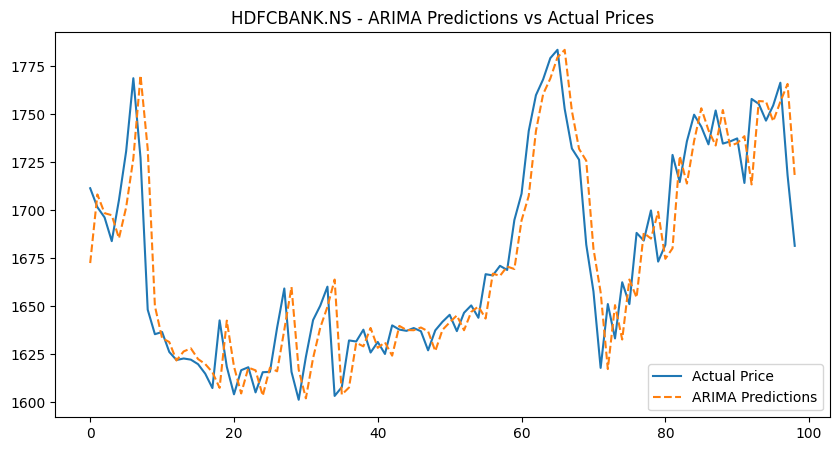

HDFCBANK.NS - ARIMA RMSE: 22.344407571727725
Tomorrow's Predicted Closing Price by ARIMA: 1717.5890344336826

Performing LSTM Prediction...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.2846
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0454
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0293
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0201
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0202
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0159
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0191
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0177
Epoch 9/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0191
Epoch 10/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0171
Epoch 11/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0155
Epoch 12/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0165
Epoch 13/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0159
Epoch 14/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0163
Epoch 15/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0156
Epoc

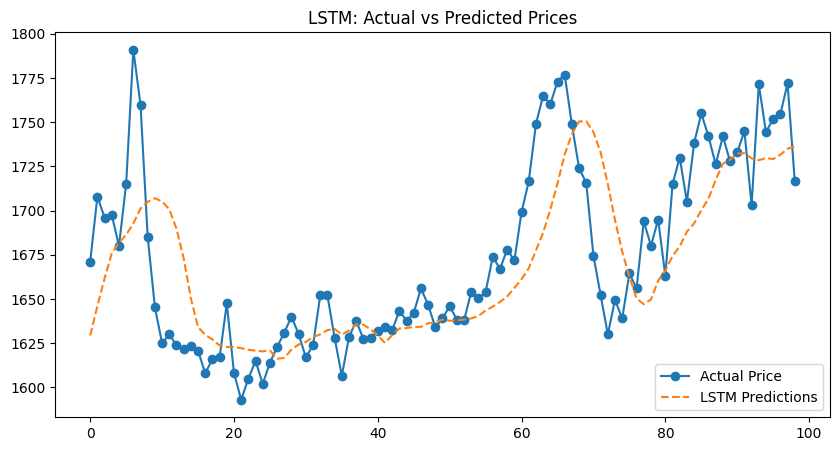

LSTM RMSE: 35.17826747995284

Performing Linear Regression Prediction...


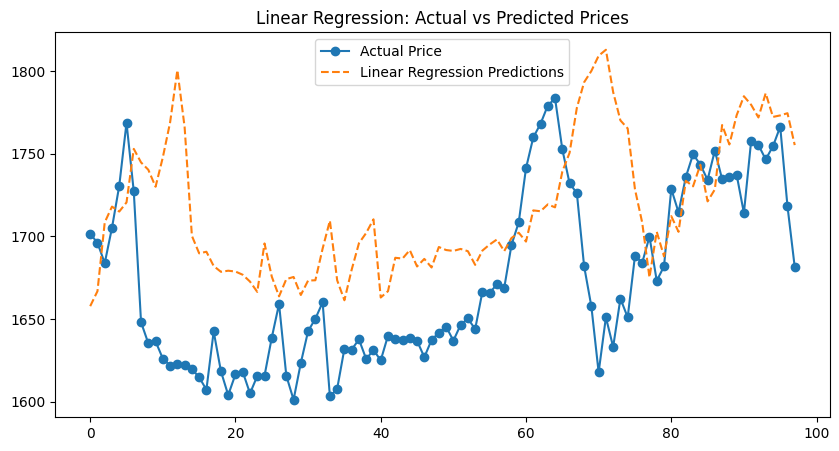

Linear Regression RMSE: 67.24879079649173

Performing Sentiment Analysis...
Fetching tweets for HDFC Bank Limited...
Global Polarity: 11.5515
Positive Tweets: 33, Negative Tweets: 8
Recommendation: Buy

All analyses completed successfully.


In [ ]:
# Main function to execute all algorithms and analysis for HDFCBANK.NS
def main():
    # Step 1: Fetch Historical Data for HDFCBANK.NS
    print("Fetching historical data for HDFCBANK.NS...")
    df = get_historical("HDFCBANK.NS")
    print("Data fetched successfully.")

    # Step 2: Perform ARIMA Prediction
    print("\nPerforming ARIMA Prediction...")
    df_arima = df.reset_index()[['Date', 'Close']].copy()  # Reset index before selecting columns
    df_arima['Code'] = "HDFCBANK.NS"  # Add a 'Code' column for ARIMA function
    ARIMA_ALGO(df_arima)

    # Step 3: Perform LSTM Prediction
    print("\nPerforming LSTM Prediction...")
    LSTM_ALGO(df)

    # Step 4: Perform Linear Regression Prediction
    print("\nPerforming Linear Regression Prediction...")
    LINEAR_REGRESSION_ALGO(df)

    # Step 5: Perform Sentiment analysis
    print("\nPerforming Sentiment Analysis...")
    retrieve_tweets_polarity("HDFCBANK.NS")

    print("\nAll analyses completed successfully.")

# Execute the main function
if __name__ == "__main__":
    main()


TRIAL

In [ ]:
# **************** IMPORT PACKAGES ********************
import requests
import csv
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import os
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from alpha_vantage.timeseries import TimeSeries
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.arima.model import ARIMA

# **************** FUNCTIONS TO FETCH DATA ***************************

def get_historical(quote):
    end = datetime.now()
    start = datetime(end.year - 2, end.month, end.day)
    data = yf.download(quote, start=start, end=end)
    df = pd.DataFrame(data=data)
    df.to_csv(f'{quote}.csv')

    if df.empty:
        ts = TimeSeries(key='N6A6QT6IBFJOPJ70', output_format='pandas')
        data, meta_data = ts.get_daily_adjusted(symbol='NSE:' + quote, outputsize='full')
        data = data.head(503).iloc[::-1].reset_index()

        df = pd.DataFrame({
            'Date': data['date'],
            'Open': data['1. open'],
            'High': data['2. high'],
            'Low': data['3. low'],
            'Close': data['4. close'],
            'Adj Close': data['5. adjusted close'],
            'Volume': data['6. volume']
        })
        df.to_csv(f'{quote}.csv', index=False)
    return df

  # ******************** ARIMA SECTION ********************
def ARIMA_ALGO(df, quote=None):
    """
    Perform ARIMA-based stock price prediction on a given DataFrame.
    If a specific company (quote) is provided, the prediction will focus on it.
    """

    # Helper function to parse dates
    def parser(x):
        return datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S%z')

    # ARIMA model implementation
    def arima_model(train, test):
        history = [x for x in train]  # Initialize with training data
        predictions = []

        for t in range(len(test)):
            model = ARIMA(history, order=(6, 1, 0))  # ARIMA(6,1,0)
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]  # Get one-step forecast
            predictions.append(yhat)
            history.append(test[t])  # Update history with observed value

        return predictions

    # Filter DataFrame if specific quote is provided
    if quote:
        df = df[df['Code'] == quote]

    unique_companies = df["Code"].unique()  # Get unique company codes

    # Iterate over companies (or just one if quote provided)
    for company in unique_companies[:10]:
        data = df[df['Code'] == company].reset_index()
        data['Price'] = data['Close']  # Use 'Close' column for prediction
        data.index = data['Date'].map(parser)  # Parse dates for index

        # Prepare training and testing data
        price_values = np.nan_to_num(data['Price'].astype(float).values)  # Handle NaN values
        train_size = int(len(price_values) * 0.80)
        train, test = price_values[:train_size], price_values[train_size:]

        # Run the ARIMA model
        predictions = arima_model(train, test)

        # Plot actual vs predicted prices
        plt.figure(figsize=(10, 5))
        plt.plot(test, label='Actual Price')
        plt.plot(predictions, label='ARIMA Predictions', linestyle='--')
        plt.title(f'{company} - ARIMA Predictions vs Actual Prices')
        plt.legend()
        plt.show()

        # Calculate RMSE
        error_arima = math.sqrt(mean_squared_error(test, predictions))
        arima_pred = predictions[-1]  # Get the last prediction

        # Print results
        print(f"{company} - ARIMA RMSE: {error_arima}")
        print(f"Tomorrow's Predicted Closing Price by ARIMA: {arima_pred}")
# **************** LINEAR REGRESSION SECTION ******************
def LINEAR_REGRESSION_ALGO(df, forecast_out=7):
    """
    Perform Linear Regression to predict stock prices n days into the future.
    Default forecast is 7 days ahead.
    """

    # Prepare the data
    df = df.reset_index()  # Reset index for clean DataFrame operations
    df['Day'] = (df['Date'] - df['Date'].min()).dt.days  # Compute days from the start
    df['Close after n days'] = df['Close'].shift(-forecast_out)  # Shift to forecast

    # Drop the last 'forecast_out' rows to avoid NaNs in target
    X = df[['Close']].values[:-forecast_out]
    y = df['Close after n days'].values[:-forecast_out].reshape(-1, 1)

    # Standardize the features
    sc = StandardScaler()
    X_train = sc.fit_transform(X[:int(0.8 * len(X))])  # First 80% for training
    X_test = sc.transform(X[int(0.8 * len(X)):])  # Last 20% for testing

    # Train the Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y[:int(0.8 * len(y))])

    # Predict stock prices and adjust the predictions
    y_pred = model.predict(X_test) * 1.04  # Adjust predictions slightly
    error_lr = math.sqrt(mean_squared_error(y[int(0.8 * len(y)):], y_pred))

    # Plot Actual vs Predicted prices
    plt.figure(figsize=(10, 5))
    plt.plot(y[int(0.8 * len(y)):], label='Actual Price', marker='o')
    plt.plot(y_pred, label='Linear Regression Predictions', linestyle='--')
    plt.title('Linear Regression: Actual vs Predicted Prices')
    plt.legend()
    plt.show()

    # Print RMSE for model evaluation
    print(f"Linear Regression RMSE: {error_lr}")

# **************** LSTM SECTION **********************
def LSTM_ALGO(df):
    """
    Perform LSTM to predict stock prices based on historical data.
    """

    # Split the dataset into training and testing sets
    train_data = df.iloc[:int(0.8 * len(df)), 4:5].values  # Close prices for training
    test_data = df.iloc[int(0.8 * len(df)):, 4:5].values    # Close prices for testing

    # Scale the features
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)

    # Prepare training data
    X_train, y_train = [], []
    for i in range(7, len(train_scaled)):
        X_train.append(train_scaled[i - 7:i, 0])
        y_train.append(train_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # Reshape for LSTM input

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.1))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=50))
    model.add(Dropout(0.1))
    model.add(Dense(units=1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=25, batch_size=32)

    # Prepare testing data
    total_data = pd.concat((df['Close'][:int(0.8 * len(df))], df['Close'][int(0.8 * len(df)):]), axis=0)
    inputs = total_data[len(total_data) - len(test_data) - 7:].values.reshape(-1, 1)
    inputs = scaler.transform(inputs)

    X_test = []
    for i in range(7, len(inputs)):
        X_test.append(inputs[i - 7:i, 0])
    X_test = np.array(X_test).reshape(len(X_test), 7, 1)

    # Make predictions
    predicted_stock_price = model.predict(X_test)
    predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.plot(test_data, label='Actual Price', marker='o')
    plt.plot(predicted_stock_price, label='LSTM Predictions', linestyle='--')
    plt.title('LSTM: Actual vs Predicted Prices')
    plt.legend()
    plt.show()

    # Print RMSE
    error_lstm = math.sqrt(mean_squared_error(test_data, predicted_stock_price))
    print(f"LSTM RMSE: {error_lstm}")

[*********************100%***********************]  1 of 1 completed



==== ARIMA Model ====
Training ARIMA model...
Forecasting for the next 7 days...


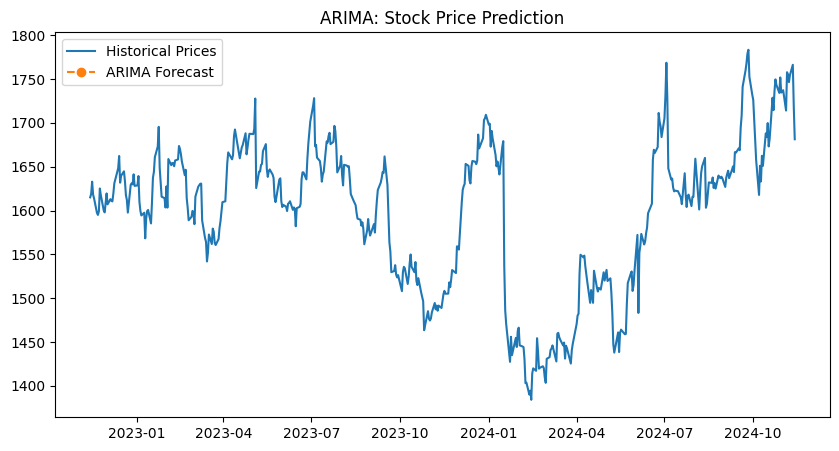

Date: 2024-11-14 | Forecasted Price: nan
Date: 2024-11-15 | Forecasted Price: nan
Date: 2024-11-16 | Forecasted Price: nan
Date: 2024-11-17 | Forecasted Price: nan
Date: 2024-11-18 | Forecasted Price: nan
Date: 2024-11-19 | Forecasted Price: nan
Date: 2024-11-20 | Forecasted Price: nan
ARIMA RMSE on Test Data: 52.40542807247307

==== Linear Regression Model ====
Linear Regression Prediction - Date: 2024-11-14 | Predicted Price: 1727.97
Linear Regression Prediction - Date: 2024-11-15 | Predicted Price: 1766.71
Linear Regression Prediction - Date: 2024-11-16 | Predicted Price: 1798.90
Linear Regression Prediction - Date: 2024-11-17 | Predicted Price: 1825.65
Linear Regression Prediction - Date: 2024-11-18 | Predicted Price: 1847.88
Linear Regression Prediction - Date: 2024-11-19 | Predicted Price: 1866.36
Linear Regression Prediction - Date: 2024-11-20 | Predicted Price: 1881.71


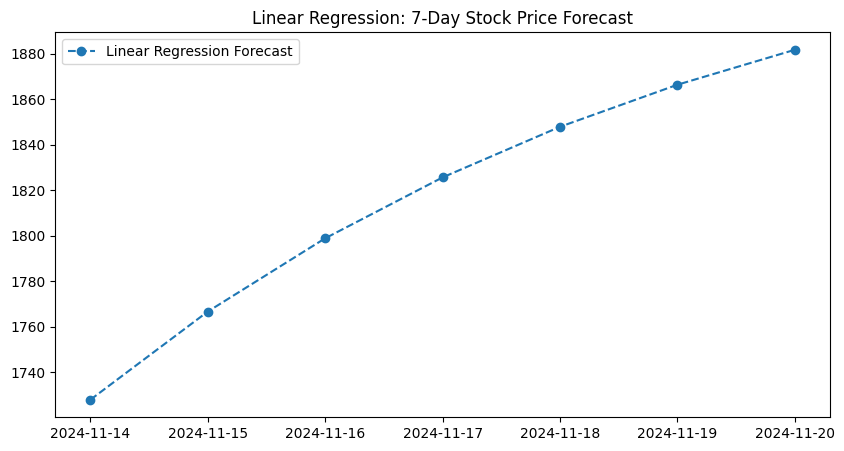


==== LSTM Model ====
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.2933
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0357
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0325
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0214
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0190
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0182
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0155
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0146
Epoch 9/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0179
Epoch 10/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0152
Epoch 11/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0151
Epoch 12/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0146
Epoch 13/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0189
Epoch 14/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0169
Epoch 15/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
LSTM Prediction - Date: 2024-11-14 | Predicted Price: 1716.99
LSTM Prediction - Date: 2024-11-15 | Predicted Price: 1716.03
LSTM Prediction - Date: 2024-11-16 | Predicted Price: 1717.23
LSTM Prediction - Date: 2024-11-17 | Predicted Price: 1716.65
LSTM Prediction - Date: 2024-11-18 | Predicted Price: 1719.02
LSTM Prediction - Date: 2024-11-19 | Predicted Price: 1722.16
LSTM Prediction - Date: 2024-11-20 | Predicted Price: 1723.59


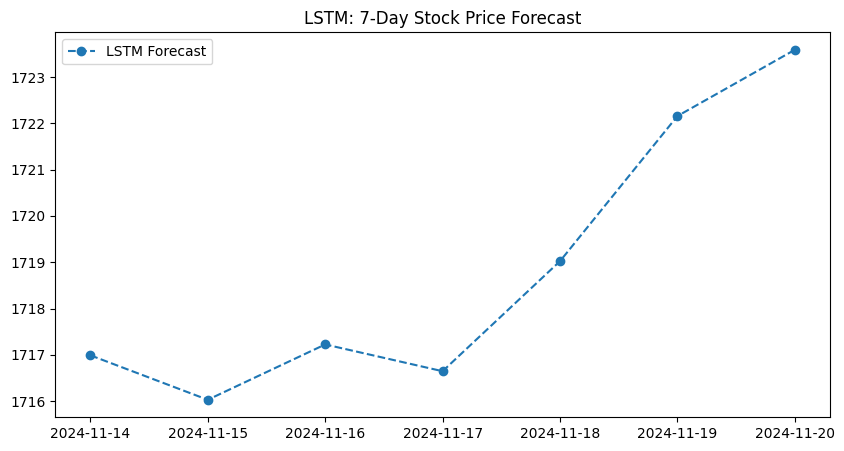

In [ ]:
# **************** IMPORT PACKAGES ********************
import requests
import csv
import yfinance as yf
from datetime import datetime, timedelta
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")

# **************** FUNCTIONS TO FETCH DATA ***************************
def get_historical(quote):
    end = datetime.now()
    start = datetime(end.year - 2, end.month, end.day)
    data = yf.download(quote, start=start, end=end)
    df = pd.DataFrame(data=data)
    df.reset_index(inplace=True)  # Ensure 'Date' column is present
    df.to_csv(f'{quote}.csv')
    if df.empty:
        ts = TimeSeries(key='N6A6QT6IBFJOPJ70', output_format='pandas')
        data, meta_data = ts.get_daily_adjusted(symbol='NSE:' + quote, outputsize='full')
        data = data.head(503).iloc[::-1].reset_index()
        df = pd.DataFrame({
            'Date': data['date'],
            'Open': data['1. open'],
            'High': data['2. high'],
            'Low': data['3. low'],
            'Close': data['4. close'],
            'Adj Close': data['5. adjusted close'],
            'Volume': data['6. volume']
        })
        df.to_csv(f'{quote}.csv', index=False)
    return df

def ARIMA_ALGO(df, forecast_days=7):
    """Perform ARIMA-based stock price prediction for the next 7 days."""

    # Ensure 'Date' column is datetime and set it as index
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    df = df[['Close']]  # Keep only 'Close' column

    # Ensure data is numeric and drop NaNs
    df = df.dropna().astype(float)

    # Split into training and testing sets (80% training, 20% testing)
    train_size = int(len(df) * 0.8)
    train, test = df.iloc[:train_size], df.iloc[train_size:]

    # Fit ARIMA model on the training data
    print("Training ARIMA model...")
    model = ARIMA(train, order=(6, 1, 0))  # Adjust (p,d,q) as needed
    model_fit = model.fit()

    # Forecast the next `forecast_days` days
    print(f"Forecasting for the next {forecast_days} days...")
    forecast = model_fit.forecast(steps=forecast_days)

    # Generate future dates for the forecast
    last_date = df.index[-1]
    future_dates = [last_date + timedelta(days=i) for i in range(1, forecast_days + 1)]

    # Convert forecast to a DataFrame for easier handling
    forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecast'])

    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df['Close'], label='Historical Prices')
    plt.plot(forecast_df.index, forecast_df['Forecast'], label='ARIMA Forecast', linestyle='--', marker='o')
    plt.title('ARIMA: Stock Price Prediction')
    plt.legend()
    plt.show()

    # Print the forecast results
    for date, price in forecast_df['Forecast'].items():
        print(f"Date: {date.date()} | Forecasted Price: {price:.2f}")

    # Calculate RMSE on the test data
    test_forecast = model_fit.forecast(steps=len(test))  # Forecast for the test set
    error_arima =  math.sqrt(mean_squared_error(test, test_forecast))
    print(f"ARIMA RMSE on Test Data: {error_arima}")
# **************** LINEAR REGRESSION SECTION ******************
def LINEAR_REGRESSION_ALGO(df, forecast_out=7):
    """Linear Regression to predict stock prices for the next 7 days."""
    df['Day'] = (df.index - df.index.min()).days  # Convert dates to numerical days
    df['Close after n days'] = df['Close'].shift(-forecast_out)

    X = df[['Close']].values[:-forecast_out]
    y = df['Close after n days'].values[:-forecast_out].reshape(-1, 1)

    sc = StandardScaler()
    X_train = sc.fit_transform(X[:int(0.8 * len(X))])
    X_test = sc.transform(X[int(0.8 * len(X)):])

    model = LinearRegression()
    model.fit(X_train, y[:int(0.8 * len(y))])

    # Predict next 7 days
    last_close = df['Close'].values[-1].reshape(1, -1)
    future_prices = []
    future_dates = [(df.index[-1] + timedelta(days=i+1)) for i in range(forecast_out)]

    for _ in range(forecast_out):
        scaled_close = sc.transform(last_close)
        predicted = model.predict(scaled_close) * 1.04  # Adjust prediction slightly
        future_prices.append(predicted[0][0])
        last_close = np.array([[predicted[0][0]]])  # Use prediction for next input

    # Print and visualize results
    for date, price in zip(future_dates, future_prices):
        print(f"Linear Regression Prediction - Date: {date.date()} | Predicted Price: {price:.2f}")

    plt.figure(figsize=(10, 5))
    plt.plot(future_dates, future_prices, marker='o', linestyle='--', label='Linear Regression Forecast')
    plt.title('Linear Regression: 7-Day Stock Price Forecast')
    plt.legend()
    plt.show()
#"""LSTM to predict stock prices for the next 7 days."""
def LSTM_ALGO(df, forecast_days=7):
    """LSTM to predict stock prices for the next 7 days."""
    scaler = MinMaxScaler()

    # Extract the 'Close' column for training and testing
    data = df[['Close']].values  # Ensure data is a 2D array
    train_data = data[:int(0.8 * len(data))]
    test_data = data[int(0.8 * len(data)):]

    # Scale the training data
    train_scaled = scaler.fit_transform(train_data)

    # Prepare the training dataset
    X_train, y_train = [], []
    for i in range(7, len(train_scaled)):
        X_train.append(train_scaled[i-7:i, 0])  # Last 7 days as input
        y_train.append(train_scaled[i, 0])      # Current day as label

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Reshape input to be 3D [samples, timesteps, features] for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.1))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(50))
    model.add(Dropout(0.1))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)

    # Prepare the input for prediction (last 7 days of data)
    inputs = data[-(7 + forecast_days):]  # Last 7 + forecast days data
    inputs = scaler.transform(inputs)

    # Create the test dataset for prediction
    X_test = []
    for i in range(7, len(inputs)):
        X_test.append(inputs[i-7:i, 0])

    X_test = np.array(X_test).reshape((len(X_test), 7, 1))  # Reshape for LSTM

    # Make predictions
    predicted_prices = model.predict(X_test)
    predicted_prices = scaler.inverse_transform(predicted_prices)

    # Generate future dates for the predictions
    future_dates = [(df.index[-1] + timedelta(days=i + 1)) for i in range(forecast_days)]

    # Print and visualize the predictions
    for date, price in zip(future_dates, predicted_prices.flatten()):
        print(f"LSTM Prediction - Date: {date.date()} | Predicted Price: {price:.2f}")

    plt.figure(figsize=(10, 5))
    plt.plot(future_dates, predicted_prices, marker='o', linestyle='--', label='LSTM Forecast')
    plt.title('LSTM: 7-Day Stock Price Forecast')
    plt.legend()
    plt.show()


# **************** MAIN EXECUTION ********************
if __name__ == "__main__":
    quote = 'HDFCBANK.NS'  # Example stock symbol (Apple Inc.)
    df = get_historical(quote)

    print("\n==== ARIMA Model ====")
    ARIMA_ALGO(df)

    print("\n==== Linear Regression Model ====")
    LINEAR_REGRESSION_ALGO(df)

    print("\n==== LSTM Model ====")
    LSTM_ALGO(df)


trial copu